# Quad-copter roll angle ragulation

In [3]:
pkg load control
s = tf('s');

---

## Inner velocity-control loop

First, we have a model $G_m$. that describes the amount of thrust produced by the motor when given a dshot-command, around the hovering operating point, decribed by the transfer function below.

$$\large G_m = \frac{K}{\tau s + 1}$$

We also have the transfer function $G_r$ that describes the angular velocity of a quadcopter, as a function of the thrust produced by its propellers and motorr.

$$\large G_r = \frac{4R}{J s + B}$$

We will also introduce the padé approximation $T_d$ of a time delay $t_d$, that naturally comes from the discrete sampling of a digital sensor, to also take this into account.

$$T_d = \frac{2-t_d s}{2+t_d s}$$

The combined plant $G_i$ of these is what we want to design controllers for, that will allow us to define a reference angle, that will then be held by the controllers.

$$G_i = G_m \cdot G_r \cdot T_d$$




z_i = 200
p_i =

  -200.0000
   -20.0000
    -0.3333



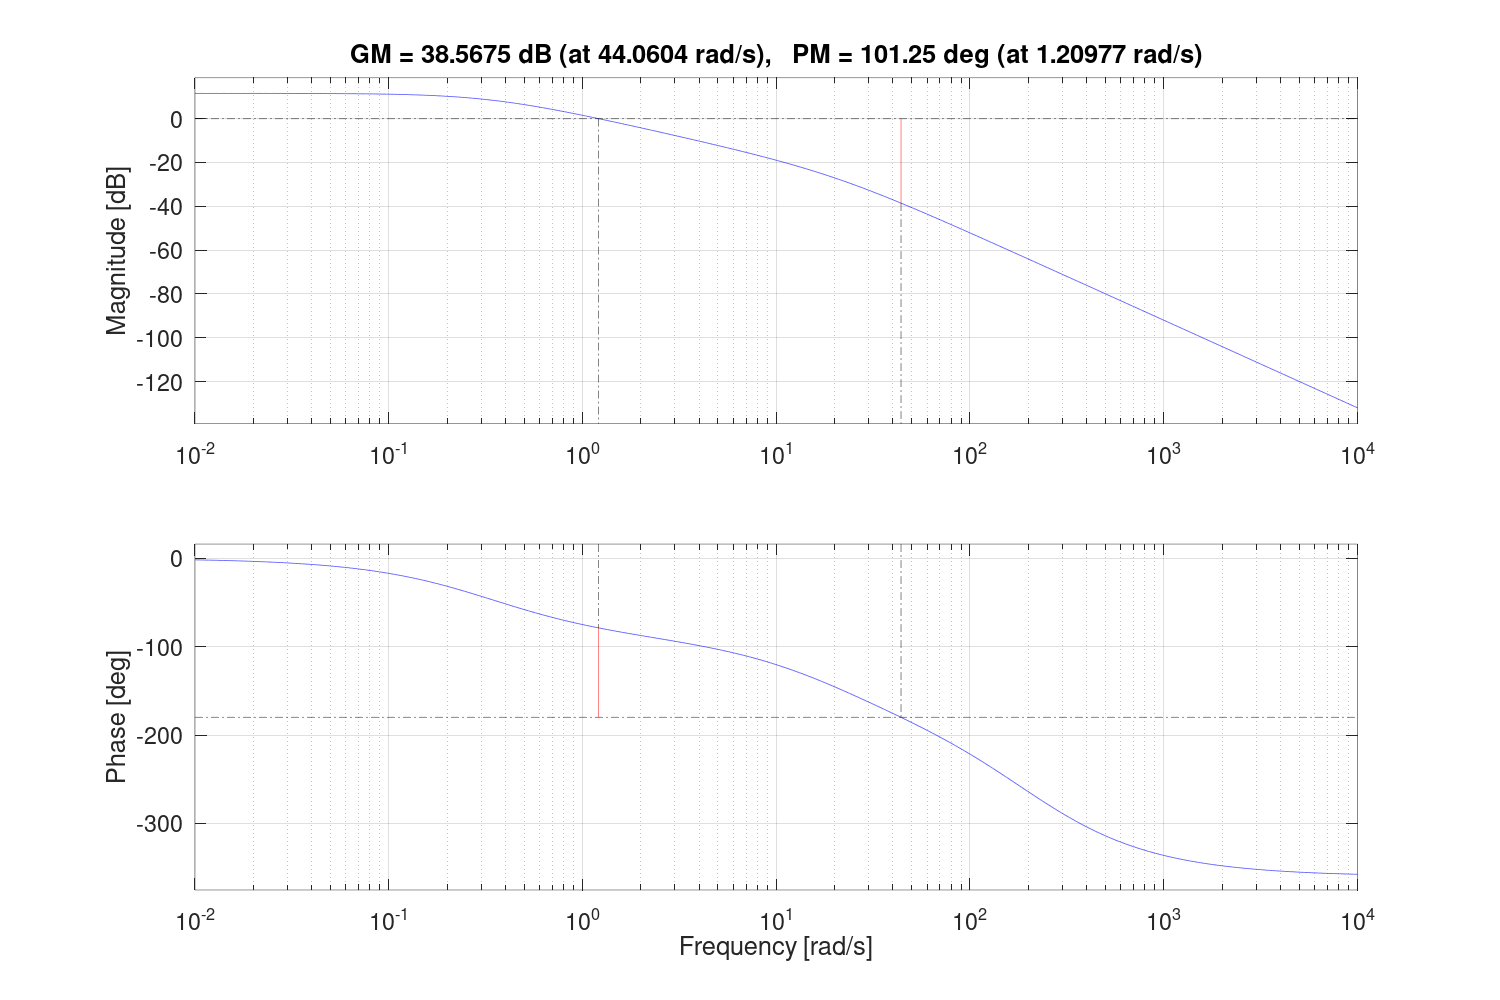

In [4]:
%% Inner velocity-control loop

K = 4.437e-3;
tau = 50e-3;

G_m = K/(tau*s+1); % Per-motor int to thrust transfer function

R = 85e-3;  % Distance between center of motor thrust vector
J = 0.0012; % Moment of inertia of drone around y-axis
B = 0.0004; % Dampening for drone on test stand

G_r = 4*R/(B+J*s); % Thrust to angular velocity transfer function

% Total time delay
delay = 10e-3;
T_d = (2-delay*s)/(2+delay*s);

G_i = G_m*G_r; % Int to angular velocity transfer function
direct_i_bf = G_i*T_d;

z_i = zero(direct_i_bf)
p_i = pole(direct_i_bf)

figure("position",[0,0,1500,1000])
margin(direct_i_bf)

### Designing controller from pole locations and bode plot

We observe from the bode plot that we have plenty of gain margin (GM) and phase margin (PM). We can however see that the gain goes to 0 dB at just 1.2 rad/s. It is possible to simply increase the gain, but only to a certain extend, before we introduce complex poles and thereby overshoot and oscillations. By viewing the root locus, and the the break points on the real axis, we can determine this gain with critical dampening.

k =

   1.8746e+04
   3.4821e+00



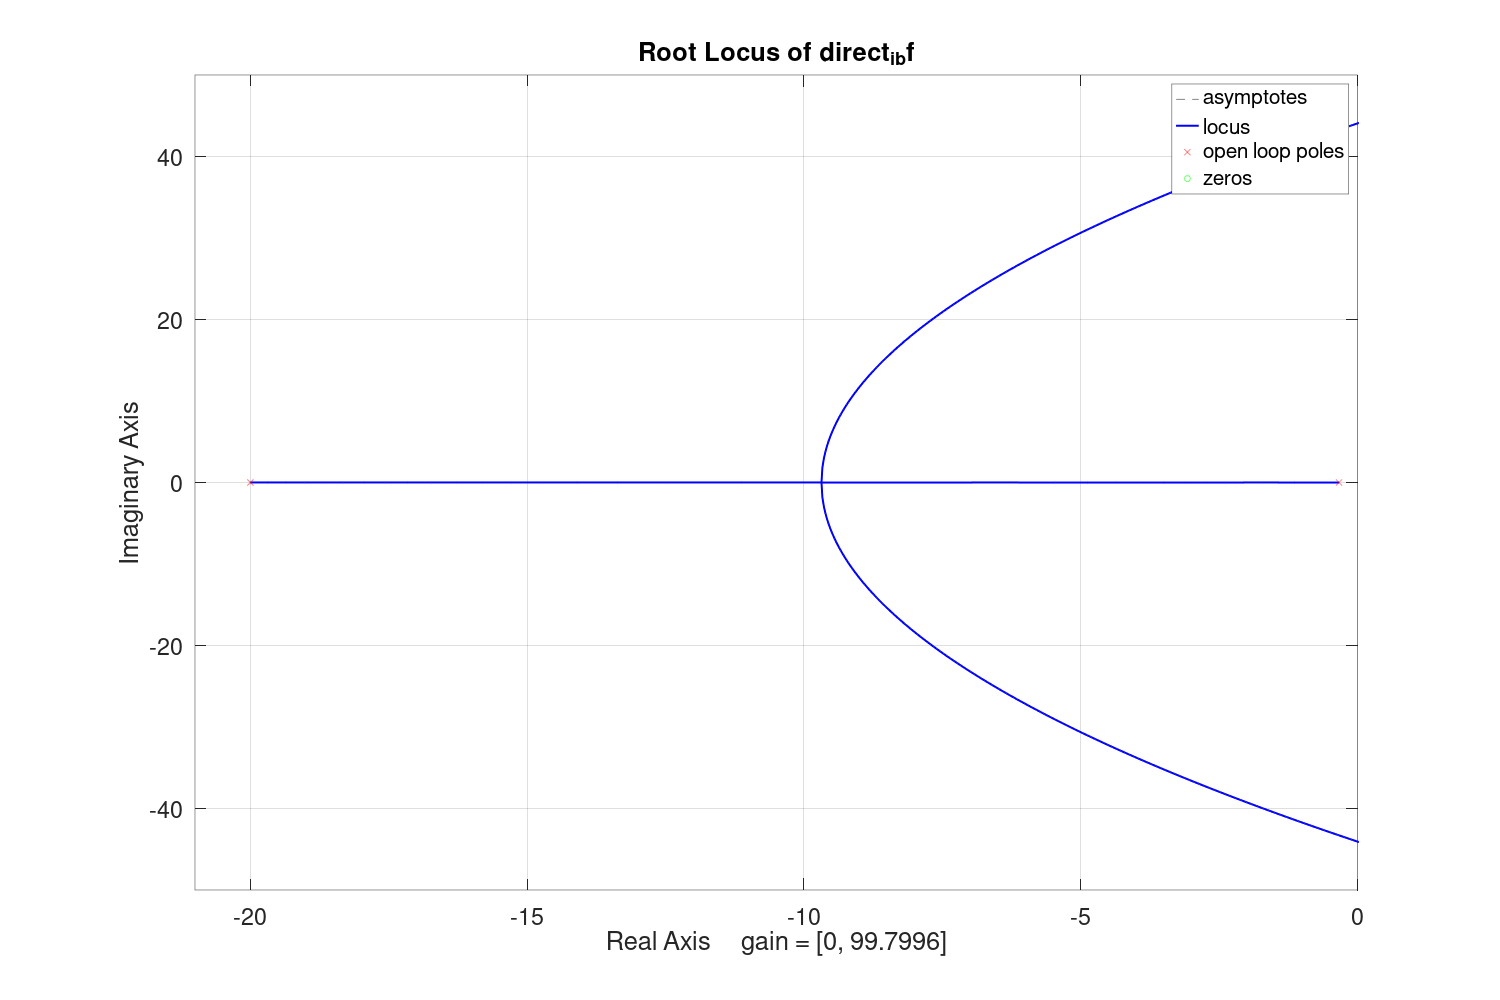

In [5]:
figure("position",[0,0,1500,1000])
[data , k] = rlocus(direct_i_bf); rlocus(direct_i_bf,0.2,0,100);
xlim([-21,0])
ylim([-50 50])
k % only one below 200 rad/s in the left-half plane

We can test wether a gain of 3.5 is enough, by doing a step, where we see that a rise time of about half a second, as well as a steady state error, is not desirable. Thus we need higher gain, and an integrator.

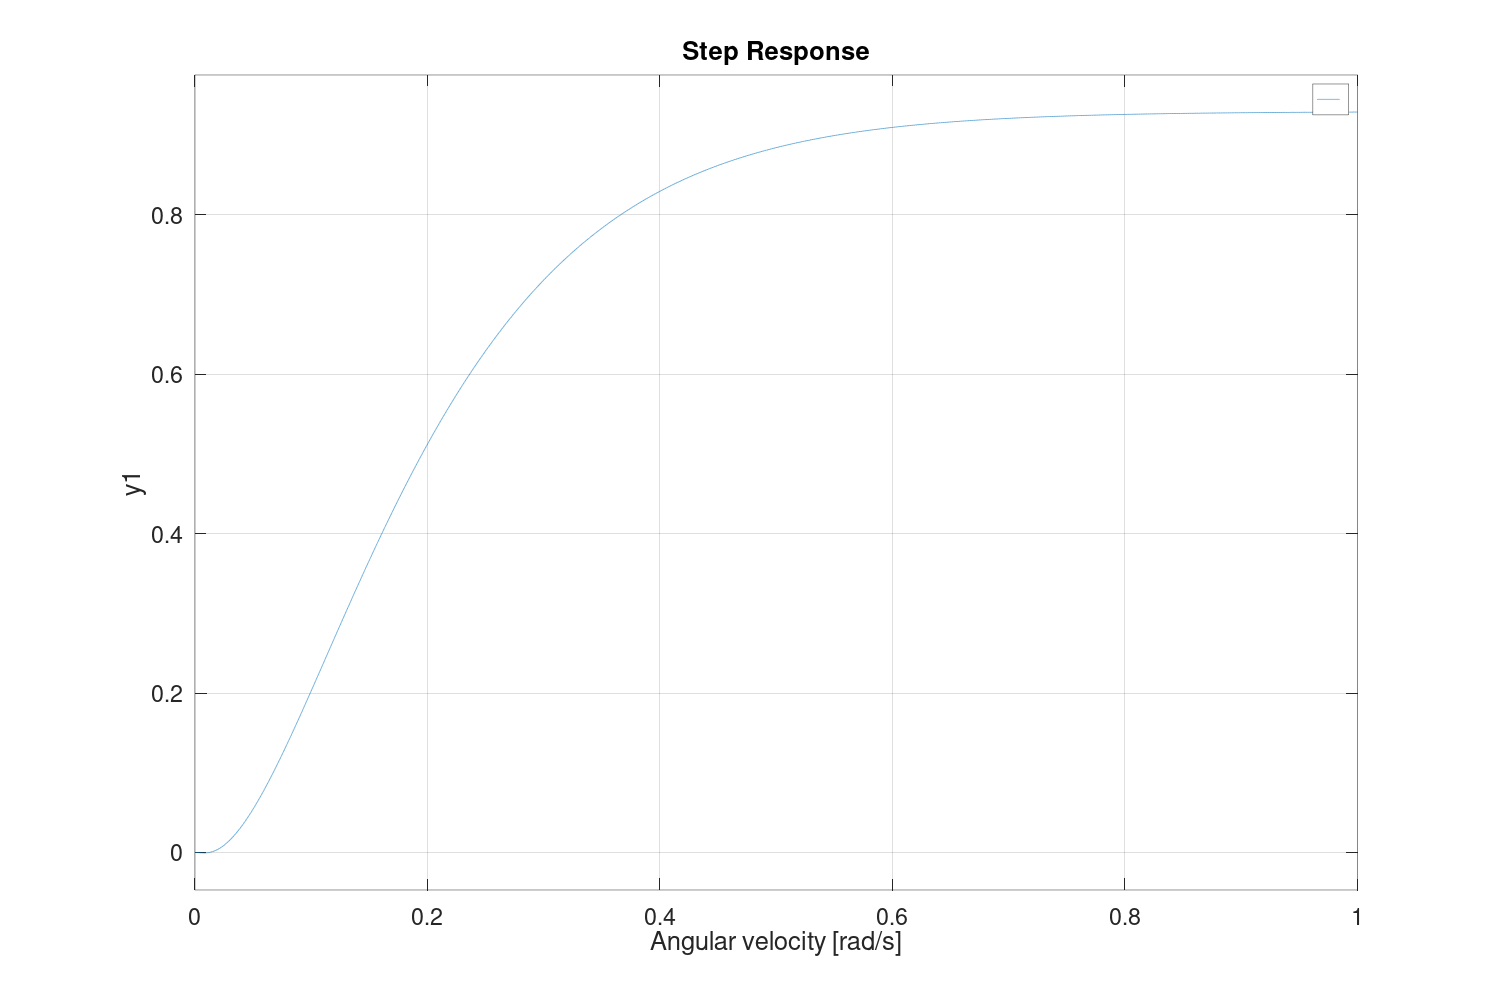

In [6]:
figure("position",[0,0,1500,1000])
step(feedback(direct_i_bf*3.5,1),1)
xlabel(["Angular velocity [rad/s]"])

In order to have higher gain, while also preventing complex poles from dominating the system, we need a controller that allows us to cancel the poles. If we use a simple PID controller, where the integrator and differentiator are made to exactly cancel the poles, we can create a new root locus to figure out how much gain we have with critical dampening.

k =

   927.8590
    27.1514
     0.3493
     0.2070



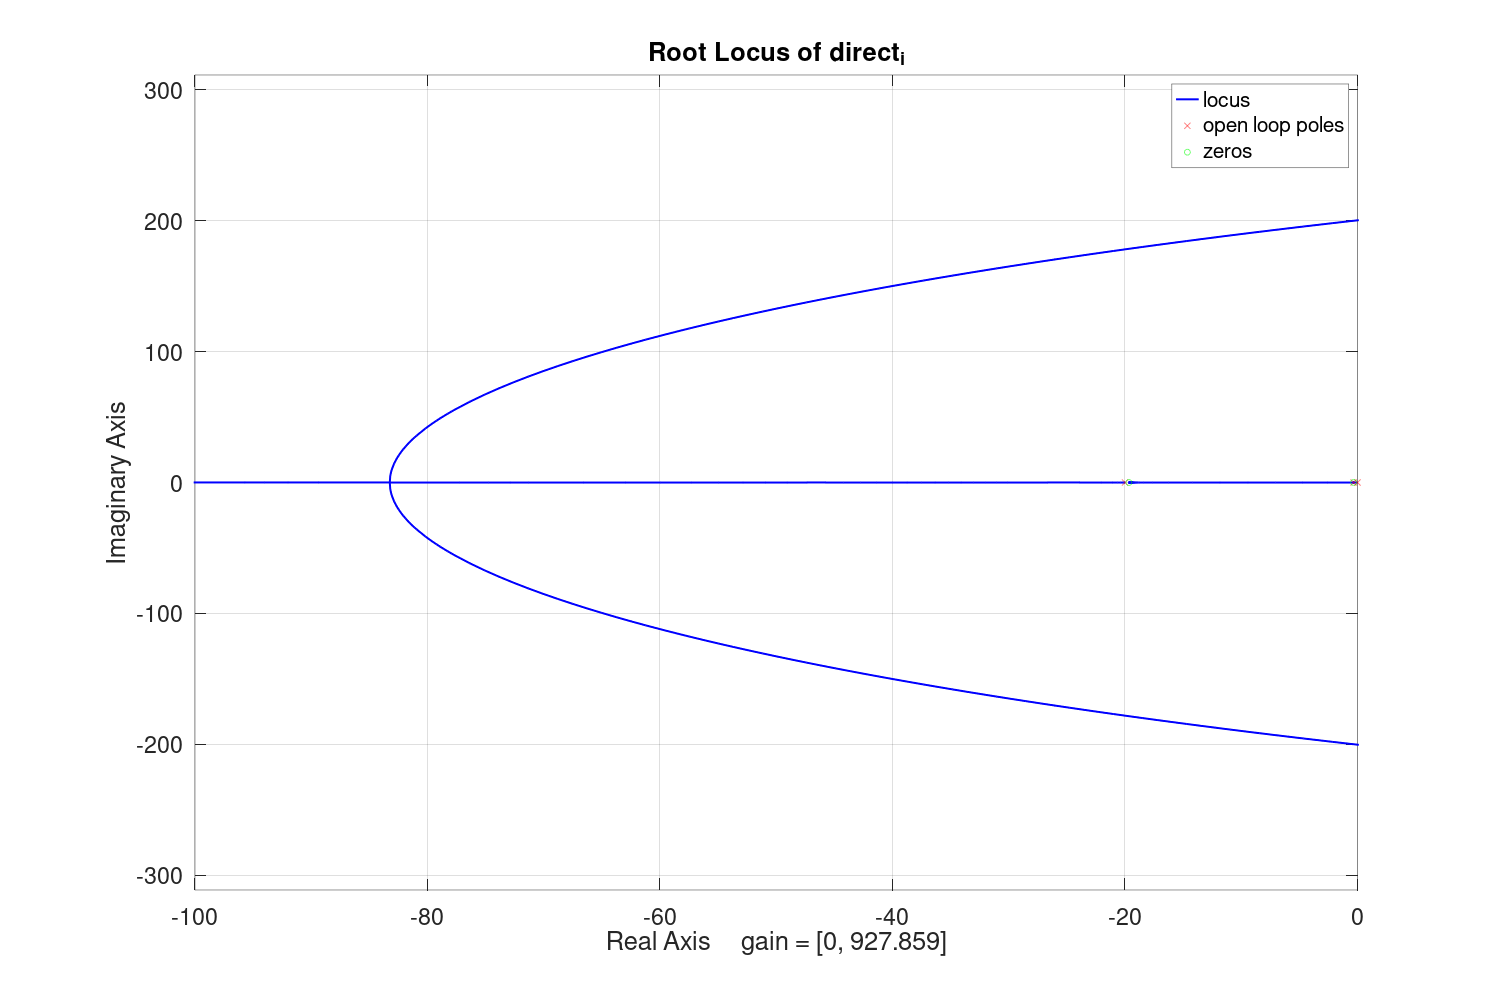

In [7]:

% PID controller
kp_i = 1; % Provides 20 dB of gain margin
ki_i = -p_i(3); % cancels out pole in -0.33 due to pitch model
kd_i = -1/p_i(2); % cancels out pole in -20 due to motor model
D_i = kp_i*(1+kd_i*s+ki_i/s);

direct_i = (direct_i_bf*D_i);

% Closed loop
figure("position",[0,0,1500,1000])
CL_i = feedback(direct_i,1);
[data , k] = rlocus(direct_i); 

rlocus(direct_i);
xlim([-100 0])
k % choose the highest one below 200 rad/s in the left-half plane

The only break point that lies within the left-half plane is the second value of k = 27.15. We can therefore choose this as our gain, and once agan check out the bode plot, to view our final gain margin and phase margin.

kp_i = 12
ki_i = 0.3333
kd_i = 0.050000


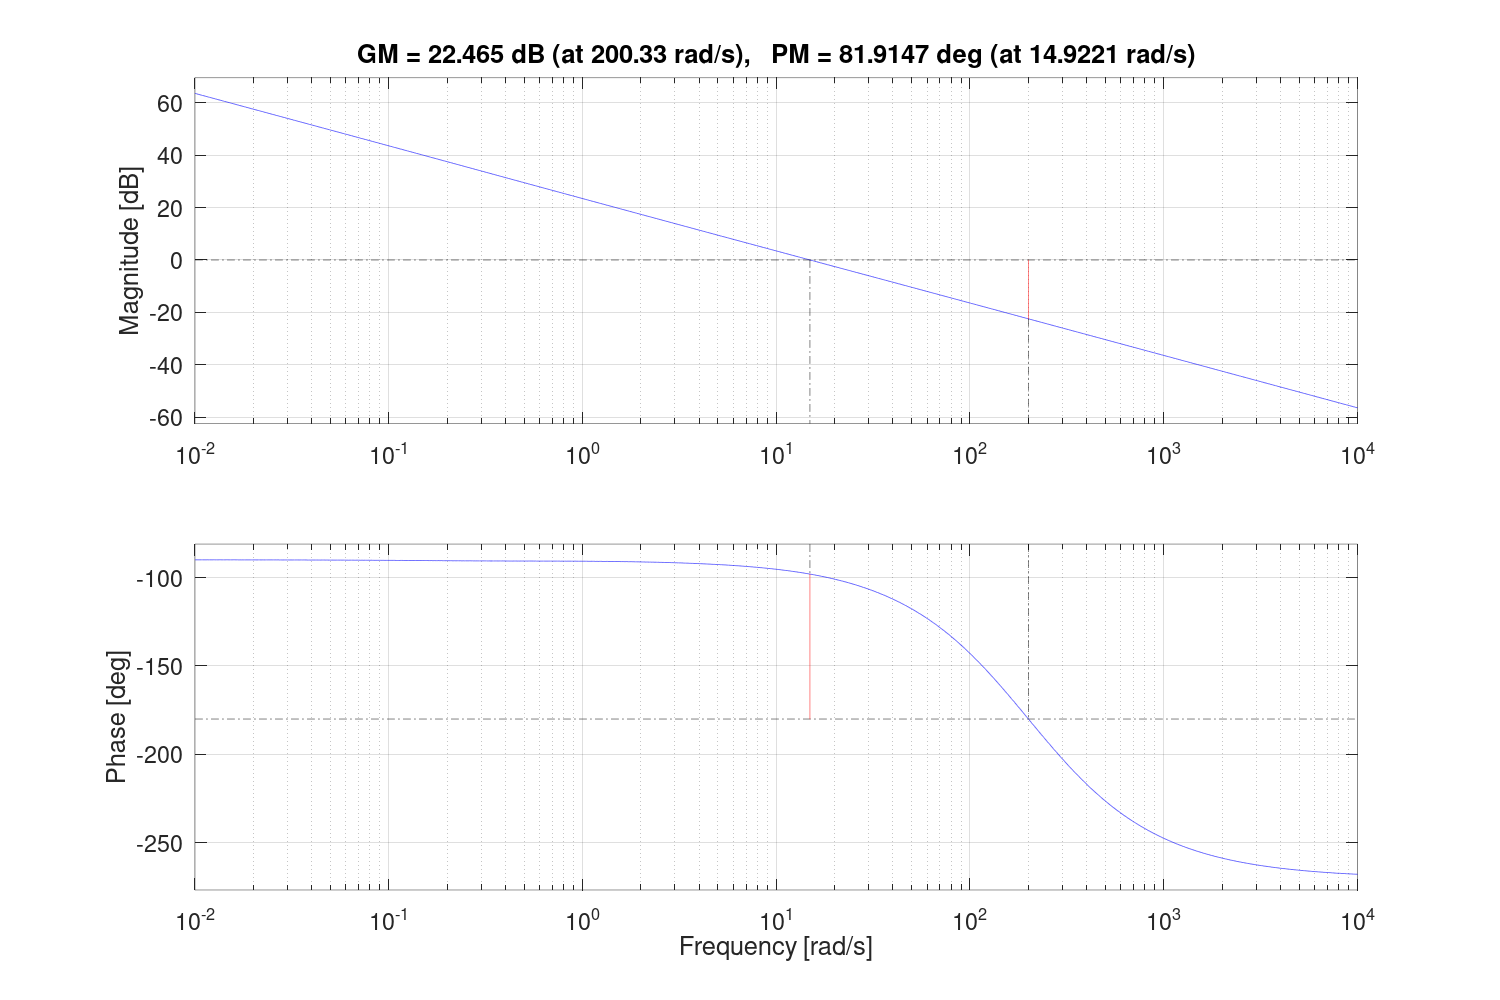

In [19]:
% PID controller
kp_i = 12 % Provides 20 dB of gain margin
ki_i = -p_i(3) % cancels out pole in -0.33 due to pitch model
kd_i = -1/p_i(2) % cancels out pole in -20 due to motor model
D_i = kp_i*(1+kd_i*s+ki_i/s);

direct_i = (T_d*G_i*D_i);

figure("position",[0,0,1500,1000])
margin(direct_i)

Finally (for the angular velocity control) we can view the step response. The slight dip we see right at the beginning of the step is due to the time delay approximation. We do however see a quite quick, and well behaving controller with no overshoot.

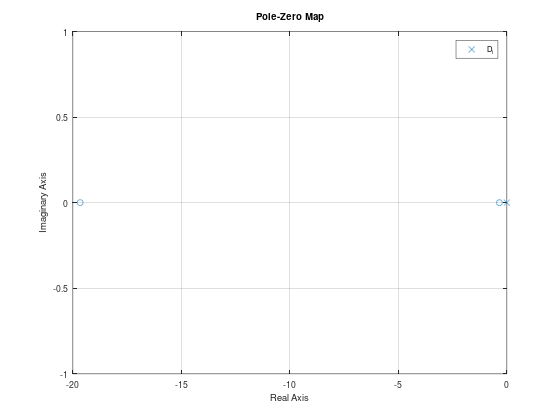

In [20]:
pzmap(D_i)

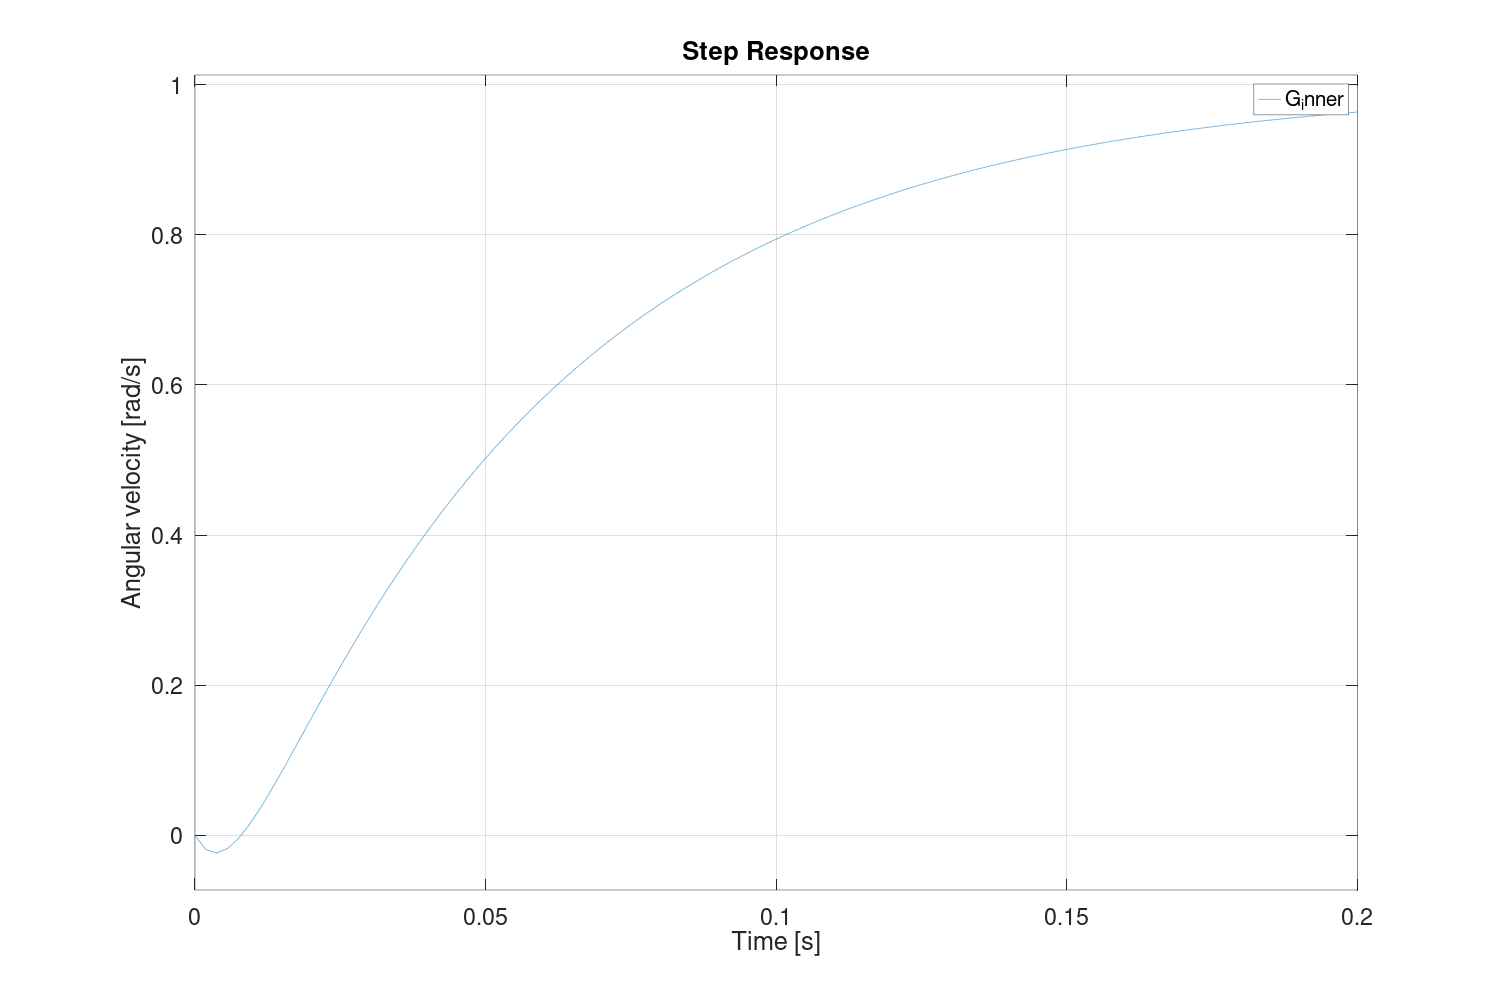

In [21]:

figure("position",[0,0,1500,1000])
G_inner = feedback(direct_i,1);
step(G_inner,0.2)
ylabel("Angular velocity [rad/s]")

---

## Outer angle-control loop

Now that the inner controller has been reduced to something that mostly behaves like a 1st order system, it is basically the same procedure for the outer controller.

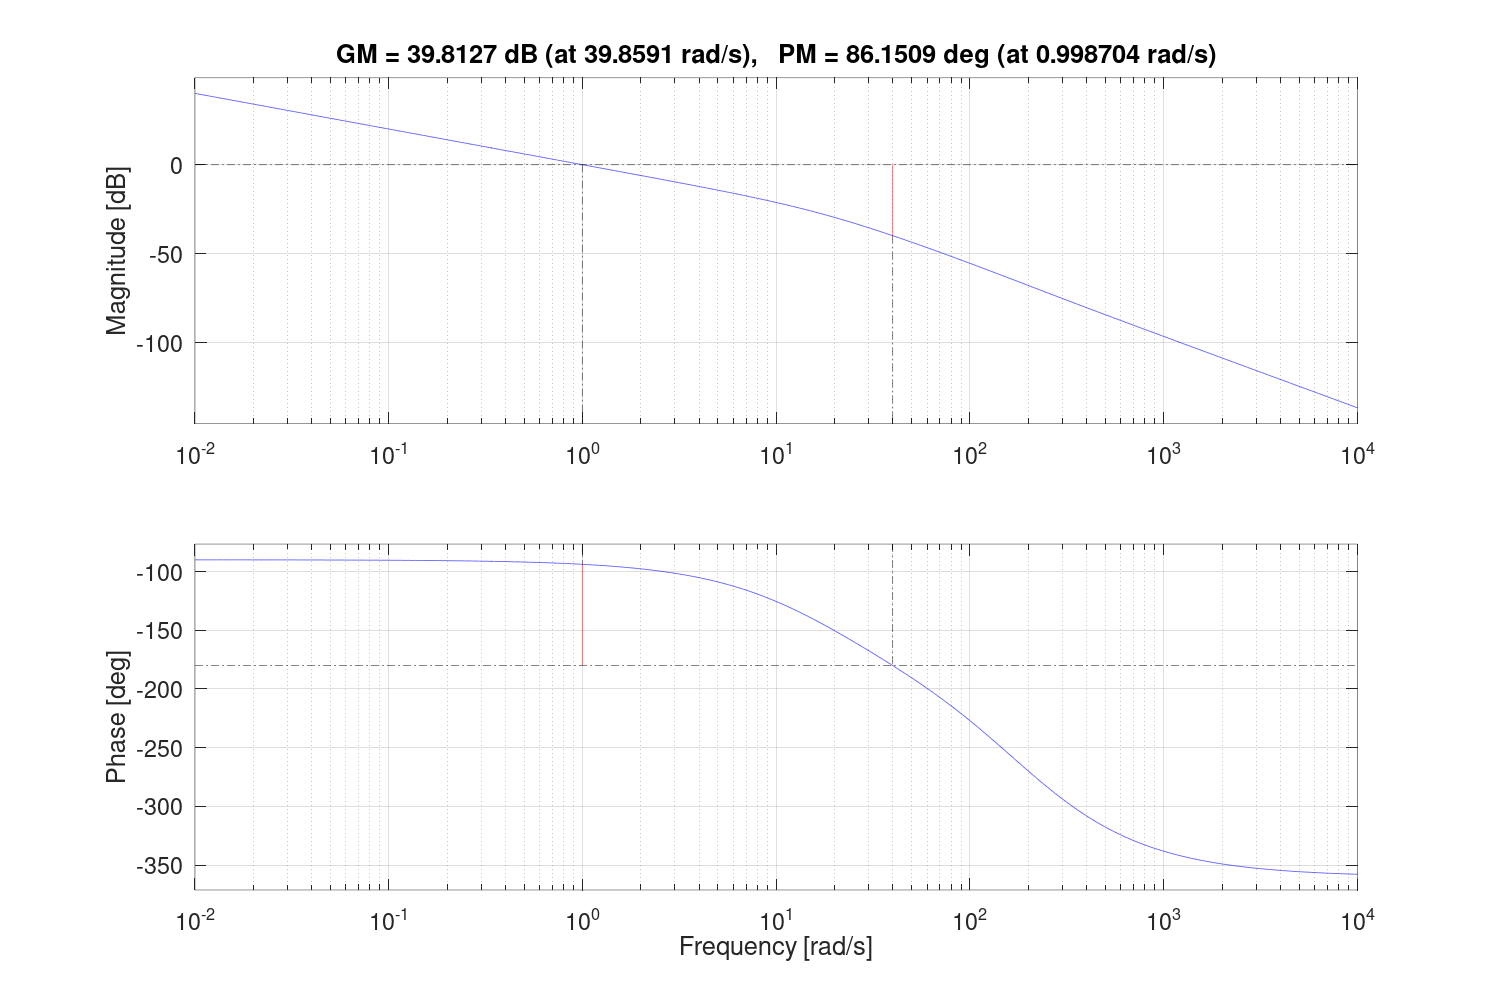

In [22]:
figure("position",[0,0,1500,1000])
margin(G_inner/s)

k =

   2.9110e+04
   3.9693e+00



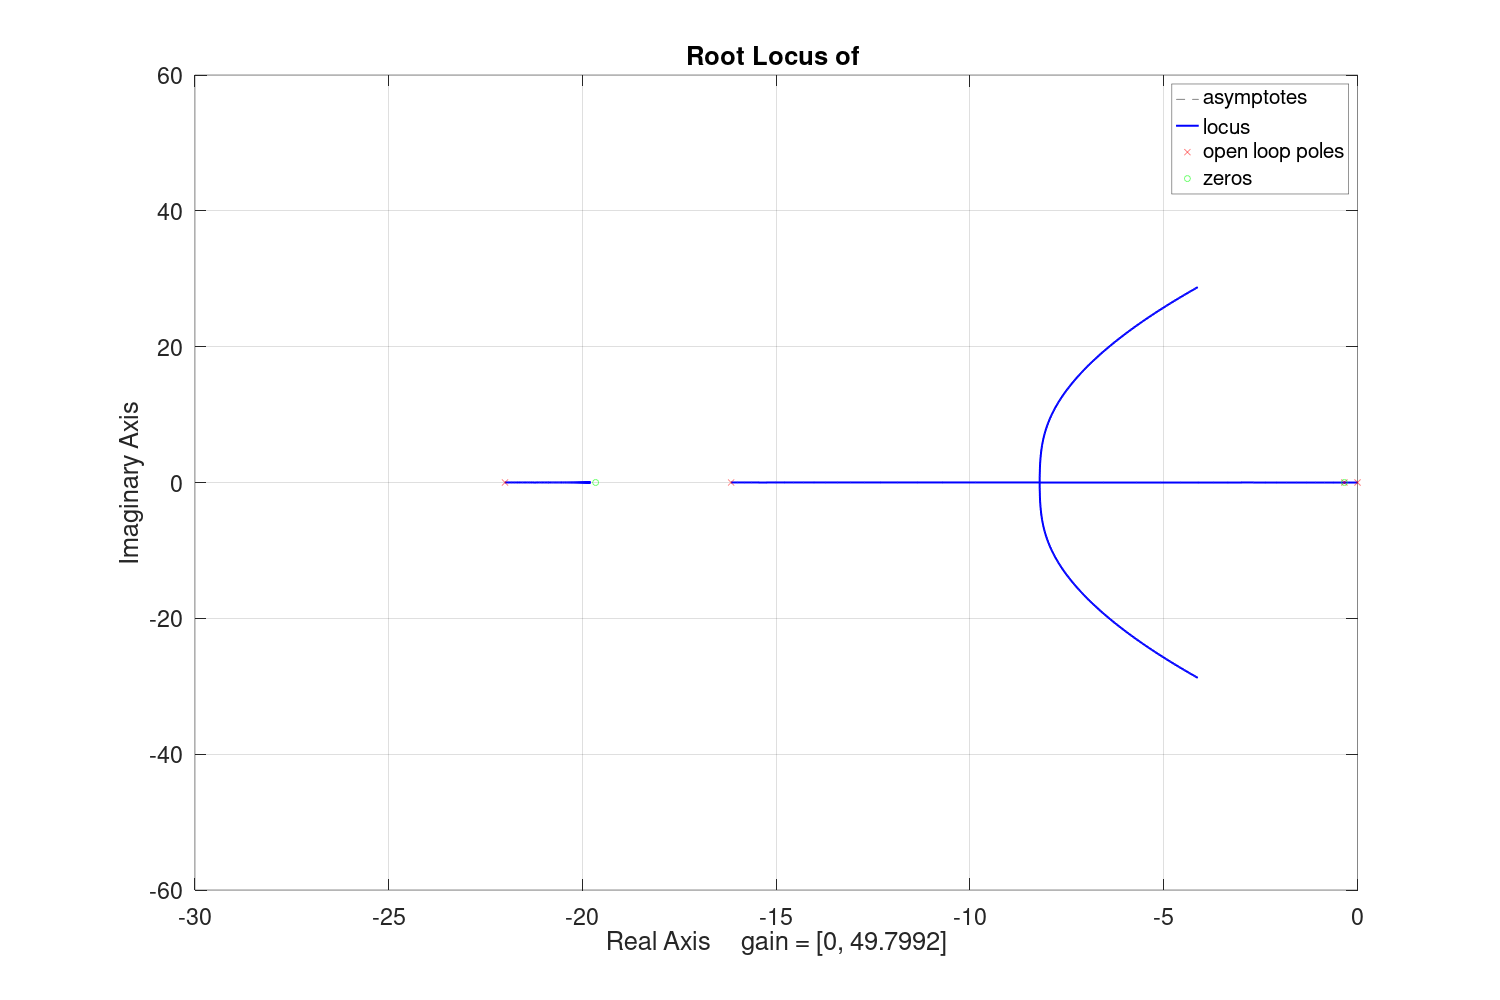

In [23]:
figure("position",[0,0,1500,1000])
[data , k] = rlocus(G_inner/s,0.2,0,50); rlocus(minreal(G_inner/s),0.2,0,50);
xlim([-30 -0])
ylim([-60 60])

k % only one below 200 rad/s in the left-half plane

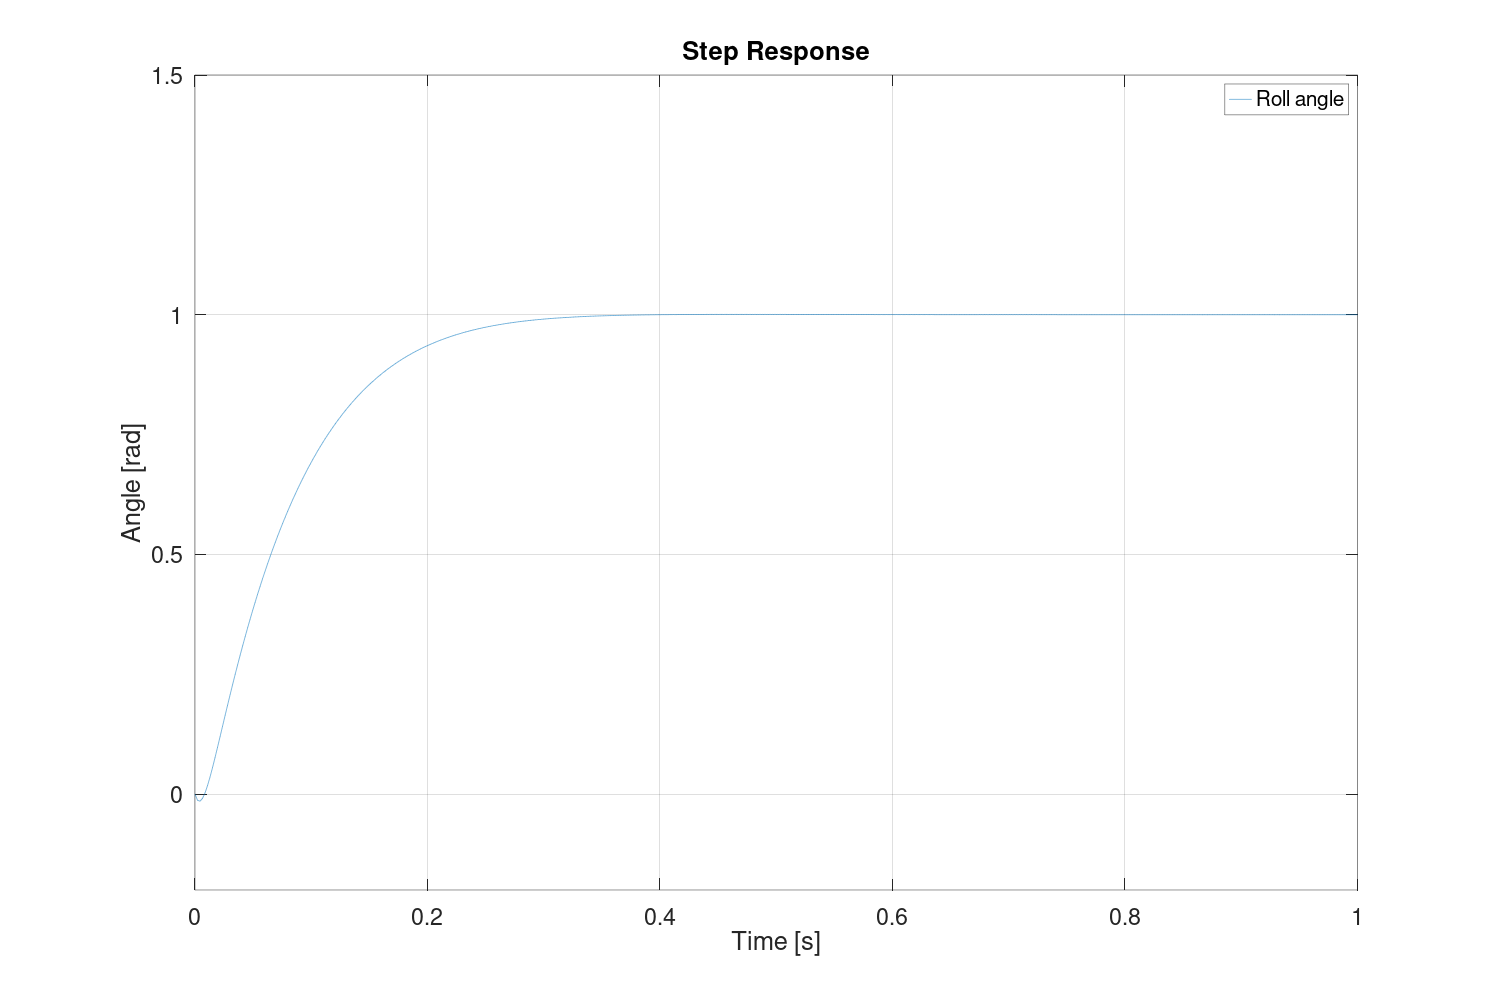

In [26]:
%% Outer angle-control loop

kp_o = 12;
ki_o = 0;
kd_o = 0.05;

% PID controller
D_o = kp_o*(1+kd_o*s+ki_o/s);
direct_o = (D_o*G_inner)/s; % integrate once to get out angle

% Closed loop
CL_o = feedback(direct_o,1);

% Step response plot
figure("position",[0,0,1500,1000])
step(CL_o,1)
ylim([-0.2 1.5])
ylabel("Angle [rad]")
legend "Roll angle"
grid on

z_o = zero(direct_o);
p_o = pole(direct_o);


In [14]:
pole(G_inner/s)

ans =

  -90.6711
  -76.0196
  -19.3604
   -0.3391
         0



k =

   1.3759e+01
   2.4857e-03



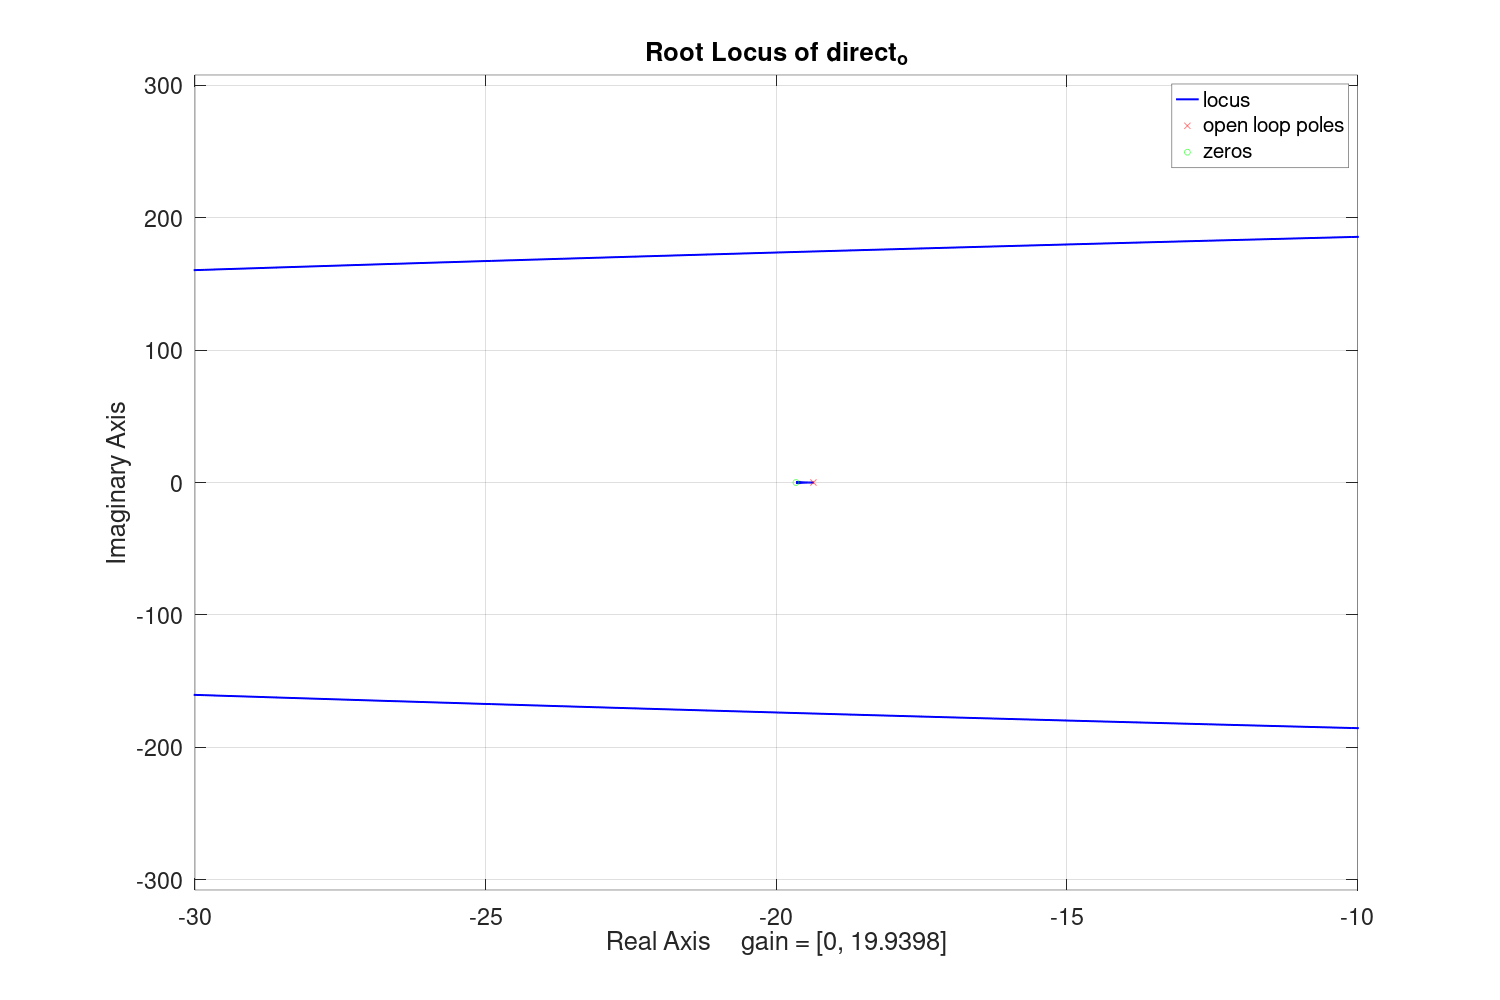

In [15]:
kp_o = 12;
ki_o = 0;
kd_o = 0.2;

% PID controller
D_o = kp_o*(1+kd_o*s+ki_o/s);
direct_o = (D_o*G_inner)/s; % integrate once to get out angle

figure("position",[0,0,1500,1000])
[data , k] = rlocus(direct_o,0.2,0,20); rlocus(direct_o,0.03,0,20);
xlim([-30 -10])
k % only one below 200 rad/s in the left-half plane

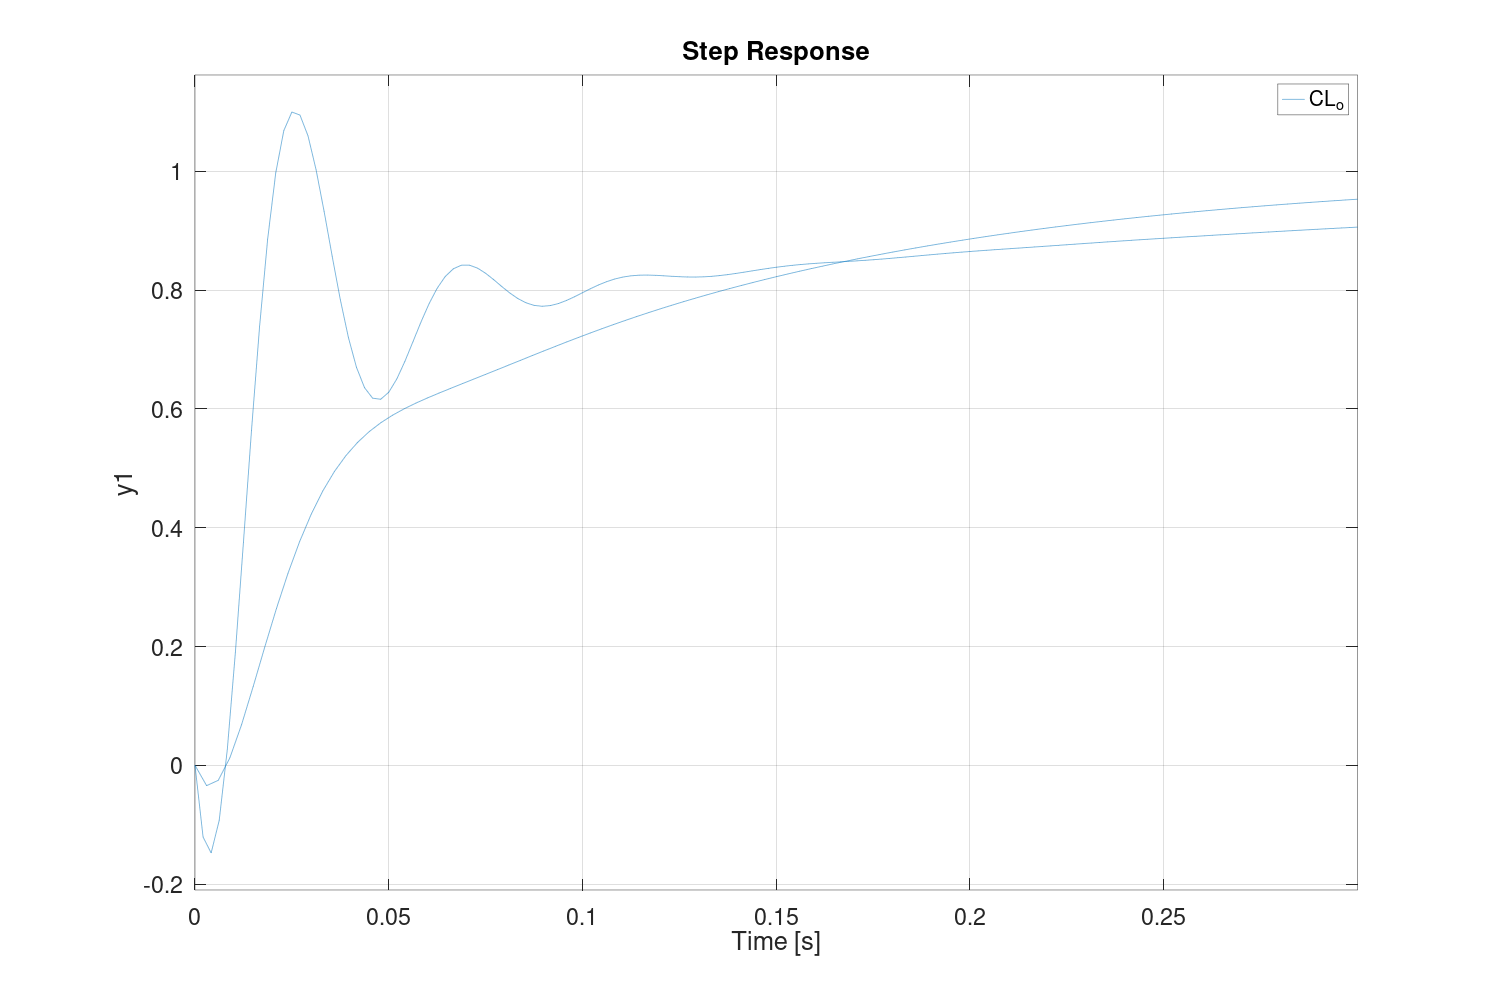

In [16]:
figure("position",[0,0,1500,1000])
step(feedback(direct_o,1),0.3)
hold on
step(CL_o,0.3)

In [17]:
kp_i
ki_i
kd_i

kp_o
ki_o
kd_o

kp_i = 27
ki_i = 0.3333
kd_i = 0.050000
kp_o = 12
ki_o = 0
kd_o = 0.2000


error: 'CL_o_meas' undefined near line 1, column 1


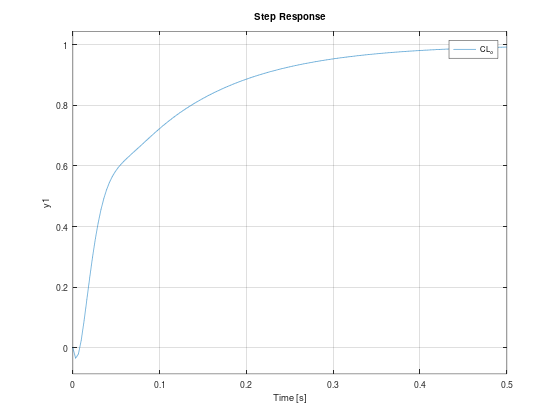

In [18]:
step(CL_o,0.5)

CL_o_meas